In [2]:
from helpers.benchmark import load_records_from_directory, filter_cpu_data
import pandas as pd

def build_stage_b_filtered_df(
    df: pd.DataFrame,
    configs: list[tuple[str, list[int]]],  # (provider, [memory_sizes])
    benchmarks: list[str],
    group_on_timestamp: bool = False,
    remove_cold: bool = True,
) -> pd.DataFrame:
    """
    Build a single DF for Stage B where filtering/outlier removal is applied per provider/memory combo.
    
    Stage B has single region per provider, so no need to iterate regions.
    """
    parts = []
    
    for provider, memory_sizes in configs:
        for memory_size in memory_sizes:
            for bench in benchmarks:
                base = df[
                    (df["provider"] == provider)
                    & (df["memory_size_mb"] == memory_size)
                    & (df["benchmark_type"] == bench)
                ]
                
                if base.empty:
                    print(f"No data for {provider} - {memory_size}MB - {bench}")
                    continue
                
                # Stage B: single region per provider, so filter without region iteration
                # (or if you have region column, you can still iterate)
                regions = base["region"].dropna().unique().tolist()
                
                if len(regions) == 0:
                    # No region info - filter whole subset
                    part = filter_cpu_data(
                        df=base,
                        provider=provider,
                        memory_size=memory_size,
                        benchmark=bench,
                        group_on_timestamp=group_on_timestamp,
                        remove_cold=remove_cold,
                        no_outlier_filter=False
                    )
                    if not part.empty:
                        parts.append(part)
                else:
                    # Has region info - filter per region (same as Stage A)
                    for r in regions:
                        part = filter_cpu_data(
                            df=base,
                            provider=provider,
                            memory_size=memory_size,
                            benchmark=bench,
                            group_on_timestamp=group_on_timestamp,
                            region=r,
                            remove_cold=remove_cold,
                            no_outlier_filter=False
                        )
                        if not part.empty:
                            parts.append(part)
    
    if not parts:
        return df.iloc[0:0].copy()
    
    out = pd.concat(parts, ignore_index=True)
    
    if "timestamp" in out.columns:
        out["timestamp"] = pd.to_datetime(out["timestamp"], utc=True)
    
    return out


# === Stage B Data Loading ===

LOG_DIR = "data/stage_b"
df_raw = load_records_from_directory(LOG_DIR)
print("loaded records:", len(df_raw))

# Stage B configs: provider -> list of memory sizes
STAGE_B_CONFIGS = [
    ("aws", [128, 512, 2048]),
    ("gcp", [128, 512, 2048]),
    ("alibaba", [128, 512, 2048]),
    ("azure", [512, 2048]),  # Azure has no 128MB tier
]

BENCHMARKS = ["gemm"]

df = build_stage_b_filtered_df(df_raw, STAGE_B_CONFIGS, BENCHMARKS)
print("raw rows:", len(df_raw))
print("filtered rows:", len(df))

# Check what we got
print("\nRecords per provider/memory:")
print(df.groupby(["provider", "memory_size_mb"]).size().unstack(fill_value=0))

loaded records: 195834
raw rows: 195834
filtered rows: 110304

Records per provider/memory:
memory_size_mb  128    512    2048
provider                          
alibaba         8694  10194  10650
aws             8928   9945  10476
azure              0  10515  10632
gcp             8490  10224  11556


Saved: plots/stage_b/boxplot_by_memory.pdf


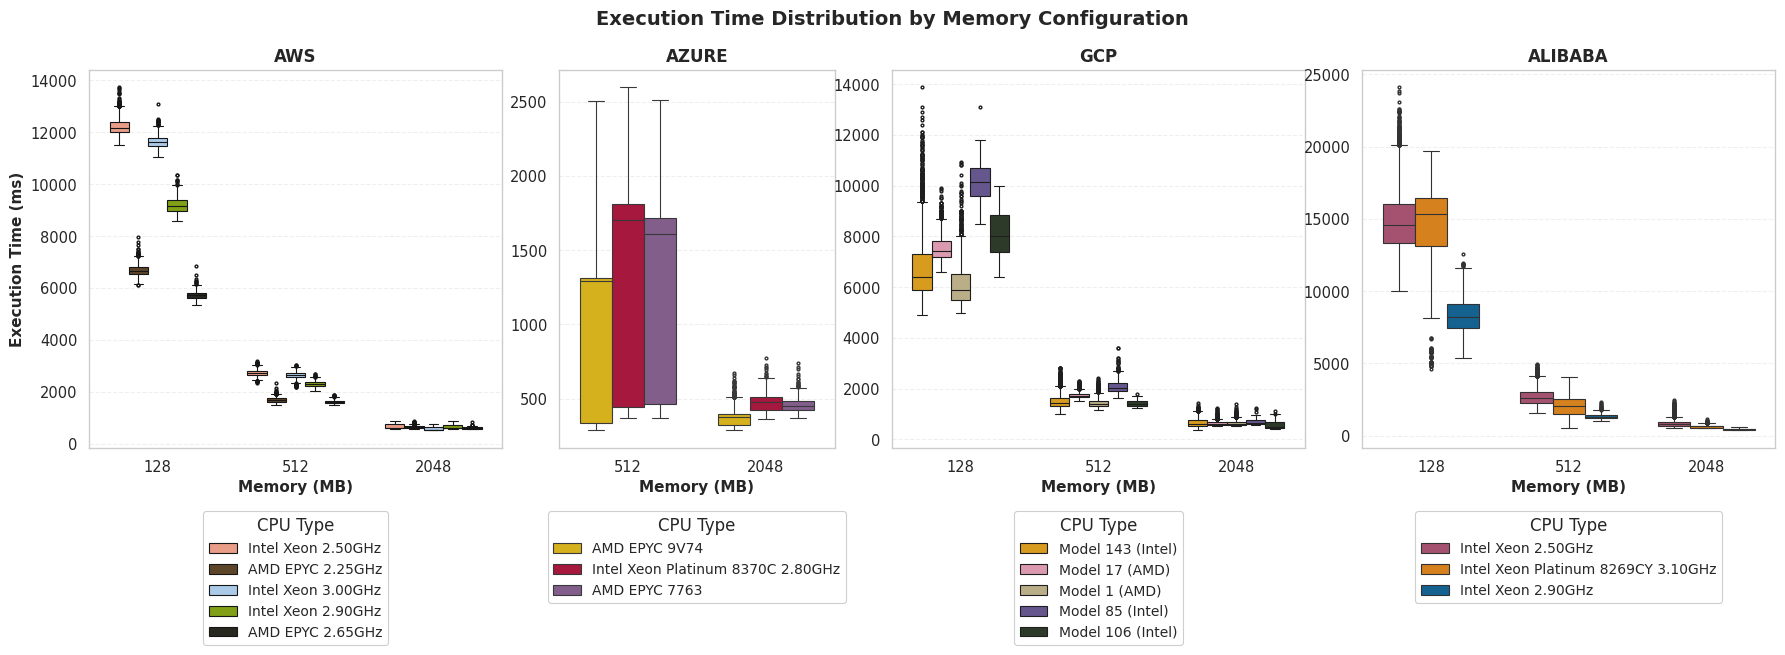

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_color

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def plot_stage_b_boxplot(
    df: pd.DataFrame,
    benchmark: str = "gemm",
    save_path: str | None = None,
    show: bool = True,
) -> plt.Figure:
    """
    Stage B: Boxplot of execution times by memory configuration and CPU type.
    
    Shows raw invocation-level distribution to reveal performance patterns
    (e.g., Azure's bimodal boosted/sustained behavior).
    
    Parameters
    ----------
    df : pd.DataFrame
        Pre-filtered DataFrame (warm invocations, outliers removed).
    benchmark : str
        Benchmark type (default: "gemm").
    save_path : str | None
        Path to save figure (creates directories if needed).
    show : bool
        Whether to display the figure.
    
    Returns
    -------
    plt.Figure
        The generated figure.
    """
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    metric = metric_for_benchmark(benchmark)
    
    # Filter to benchmark
    plot_df = df[df["benchmark_type"] == benchmark].copy()
    
    if plot_df.empty:
        print(f"❌ No data for benchmark: {benchmark}")
        return None
    
    # Shorten CPU names for readability
    plot_df["cpu_short"] = plot_df["cpu_type"].apply(shorten_cpu_name)
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(
        1, 4, figsize=(18, 6), sharey=False,
        gridspec_kw={"width_ratios": [3, 2, 3, 3]}
    )
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        provider_memories = [512, 2048] if provider == "azure" else memory_sizes
        
        # Filter for this provider
        prov_df = plot_df[plot_df["provider"] == provider].copy()
        
        if prov_df.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", 
                    transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{provider.upper()}", fontweight="bold")
            ax.set_xlabel("Memory (MB)", fontweight="bold", fontsize=11)
            continue
        
        # Stable CPU order (by overall instance frequency)
        cpu_order = (
            prov_df.groupby("cpu_type")["instance_id"]
            .nunique()
            .sort_values(ascending=False)
            .index
            .tolist()
        )
        cpu_short_order = [shorten_cpu_name(c) for c in cpu_order]
        
        # Build palette
        palette = {
            shorten_cpu_name(cpu): get_cpu_color(cpu, provider) 
            for cpu in cpu_order
        }
        
        # Order memory as categorical
        prov_df["memory_size_mb"] = pd.Categorical(
            prov_df["memory_size_mb"], 
            categories=provider_memories, 
            ordered=True
        )
        
        # Order CPU short names
        prov_df["cpu_short"] = pd.Categorical(
            prov_df["cpu_short"],
            categories=cpu_short_order,
            ordered=True
        )
        
        sns.boxplot(
            data=prov_df,
            x="memory_size_mb",
            y=metric,
            hue="cpu_short",
            palette=palette,
            hue_order=cpu_short_order,
            ax=ax,
            linewidth=0.8,
            fliersize=2,
            width=0.7,
        )
        
        ax.set_title(f"{provider.upper()}", fontweight="bold", fontsize=12)
        ax.set_xlabel("Memory (MB)", fontweight="bold", fontsize=11)
        
        if idx == 0:
            ax.set_ylabel("Execution Time (ms)", fontweight="bold", fontsize=11)
        else:
            ax.set_ylabel("")
        
        ax.grid(True, axis="y", linestyle="--", alpha=0.3)
        
        # Legend below plot
        ax.legend(
            title="CPU Type",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            framealpha=0.95,
            fontsize=10,
            title_fontsize=12,
            ncol=1,
        )
    
    fig.suptitle(
        "Execution Time Distribution by Memory Configuration",
        fontsize=14, fontweight="bold", y=0.98
    )
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.25, wspace=0.15)
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig


# === Usage ===
fig = plot_stage_b_boxplot(
    df,  # Pre-filtered via build_stage_b_filtered_df
    benchmark="gemm",
    save_path="plots/stage_b/boxplot_by_memory.pdf"
)

💾 Saved to: plots/stage_b/azure_ecdf_memory.pdf


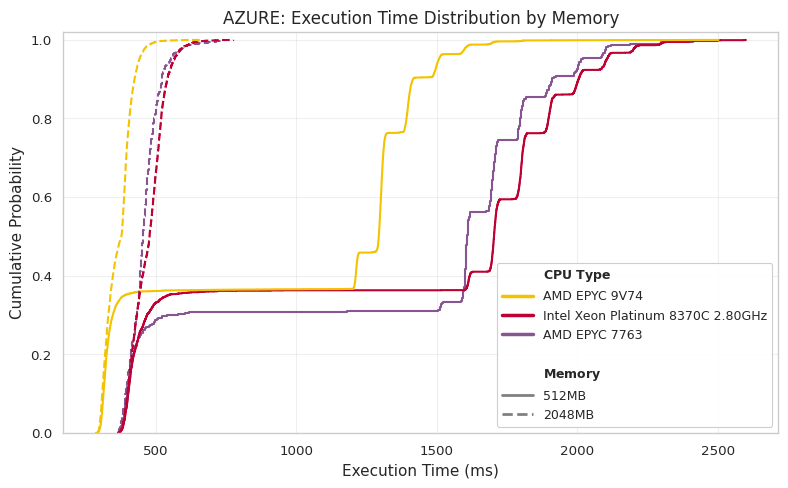

💾 Saved to: plots/stage_b/aws_ecdf_memory.pdf


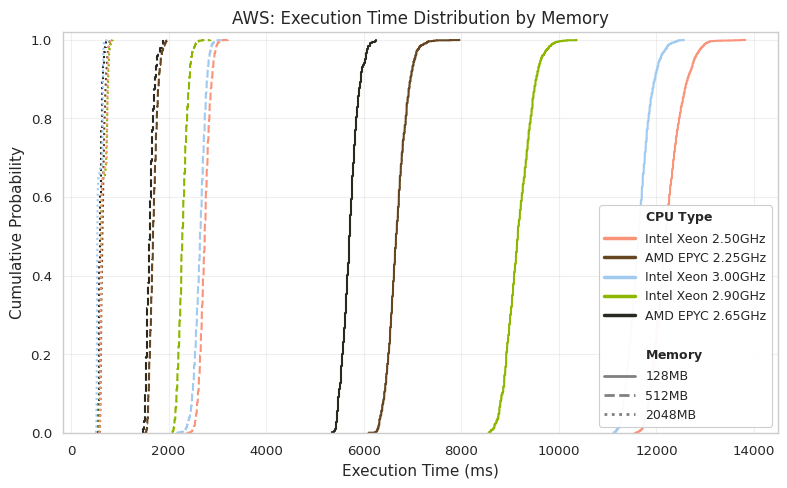

💾 Saved to: plots/stage_b/gcp_ecdf_memory.pdf


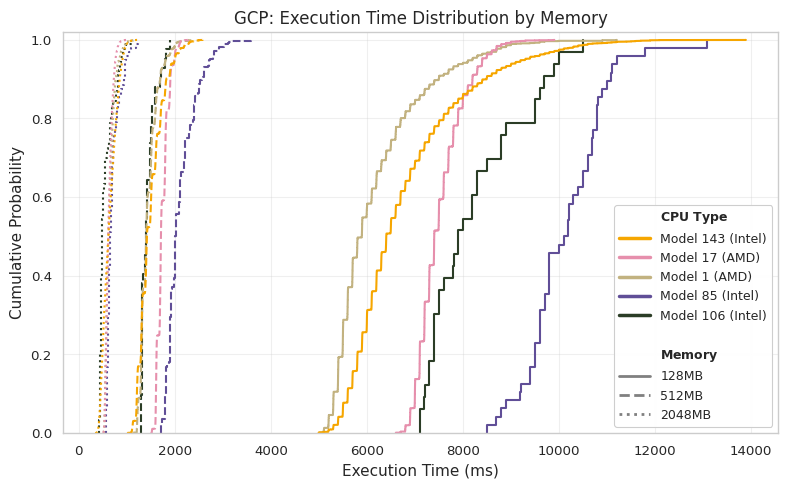

💾 Saved to: plots/stage_b/alibaba_ecdf_memory.pdf


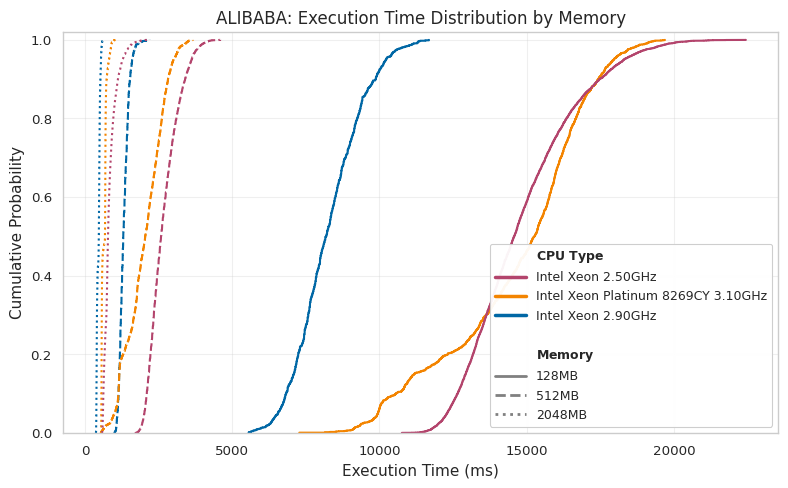

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_color


def plot_ecdf_by_memory(
    df: pd.DataFrame,
    provider: str,
    benchmark: str = "gemm",
    memory_configs: list[int] | None = None,
    title: str | None = None,
    xlim: float | None = None,
    save_path: str | None = None,
    show: bool = True,
):
    """
    ECDF plot showing performance distribution by memory tier.
    
    Expects df to be pre-filtered (warm invocations, outliers removed).
    Uses seaborn ecdfplot with different line styles per memory config.
    """
    
    # Determine memory configs if not specified
    if memory_configs is None:
        available = df[
            (df["provider"] == provider) & 
            (df["benchmark_type"] == benchmark)
        ]["memory_size_mb"].unique()
        memory_configs = sorted(available)
    
    # Subset data
    provider_df = df[
        (df["provider"] == provider) &
        (df["benchmark_type"] == benchmark) &
        (df["memory_size_mb"].isin(memory_configs))
    ].copy()
    
    if provider_df.empty:
        print(f"No data found for {provider} - {benchmark}")
        return None
    
    # Shorten CPU names using helper function
    provider_df["cpu_short"] = provider_df["cpu_type"].apply(shorten_cpu_name)
    
    # Get CPU order by frequency
    cpu_order = (
        provider_df.groupby("cpu_short")
        .size()
        .sort_values(ascending=False)
        .index.tolist()
    )
    
    # Build color palette using helper function
    palette = {
        shorten_cpu_name(cpu): get_cpu_color(cpu, provider) 
        for cpu in provider_df["cpu_type"].unique()
    }
    
    # Line styles for memory configs
    line_styles = ["-", "--", ":", "-."]
    style_map = {
        mem: line_styles[i % len(line_styles)] 
        for i, mem in enumerate(memory_configs)
    }
    
    # Get metric field
    metric_field = metric_for_benchmark(benchmark)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Plot each memory config with different line styles
    for mem in memory_configs:
        mem_subset = provider_df[provider_df["memory_size_mb"] == mem]
        
        if mem_subset.empty:
            continue
            
        sns.ecdfplot(
            data=mem_subset,
            x=metric_field,
            hue="cpu_short",
            hue_order=cpu_order,
            palette=palette,
            linestyle=style_map[mem],
            linewidth=1.5,
            ax=ax,
            legend=False
        )
    
    ax.set_xlabel("Execution Time (ms)", fontsize=11)
    ax.set_ylabel("Cumulative Probability", fontsize=11)
    
    if title is None:
        title = f"{provider.upper()}: Execution Time Distribution by Memory"
    ax.set_title(title, fontsize=12)
    
    # === Custom legend with two sections ===
    legend_elements = []
    
    # Section 1: CPU Types
    legend_elements.append(Line2D([0], [0], color="none", label="$\\bf{CPU\\ Type}$"))
    for cpu_short in cpu_order:
        legend_elements.append(
            Line2D([0], [0], color=palette[cpu_short], linewidth=2.5, label=cpu_short)
        )
    
    # Spacer
    legend_elements.append(Line2D([0], [0], color="none", label=""))
    
    # Section 2: Memory configs
    legend_elements.append(Line2D([0], [0], color="none", label="$\\bf{Memory}$"))
    for mem in memory_configs:
        legend_elements.append(
            Line2D([0], [0], color="gray", linestyle=style_map[mem], 
                   linewidth=2, label=f"{mem}MB")
        )
    
    ax.legend(
        handles=legend_elements, 
        loc="lower right", 
        framealpha=0.95, 
        fontsize=9, 
        handlelength=2.5
    )
    
    ax.set_ylim(0, 1.02)
    if xlim is not None:
        ax.set_xlim(0, xlim)
    
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"💾 Saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig


# === Usage ===

# Azure main plot
fig_azure = plot_ecdf_by_memory(
    df, 
    provider="azure", 
    memory_configs=[512, 2048],
    save_path="plots/stage_b/azure_ecdf_memory.pdf"
)

# Appendix plots
fig_aws = plot_ecdf_by_memory(df, provider="aws", memory_configs=[128, 512, 2048],
                               save_path="plots/stage_b/aws_ecdf_memory.pdf")
fig_gcp = plot_ecdf_by_memory(df, provider="gcp", memory_configs=[128, 512, 2048],
                               save_path="plots/stage_b/gcp_ecdf_memory.pdf")
fig_alibaba = plot_ecdf_by_memory(df, provider="alibaba", memory_configs=[128, 512, 2048],
                                   save_path="plots/stage_b/alibaba_ecdf_memory.pdf")

                                        uuid  new_container  invocation_count
19641   bf0bcc8f-3048-400d-b45a-21a839d44336              0                 2
19663   358d7548-1f01-4b2f-b871-8d02d2e94c05              0                 2
19677   83ba31f5-75fd-41ba-9689-c19a7385d988              0                 2
19678   f06582a0-6511-49f2-b5d5-6652bbfdc459              0                 2
19680   25d4d51e-5b29-4ebb-a98c-38b267851c97              0                 2
...                                      ...            ...               ...
195829  5d5017b7-1c96-492d-8104-e40f5898d609              0                 2
195830  899f0a57-4135-47e8-8ba6-3921f342884d              0                 2
195831  7a515aa9-3f03-4ca0-8982-b62ced51d0cd              0                 2
195832  8d0c1125-5557-48d2-bf9e-bca1a64b12ed              0                 2
195833  f10b3814-f753-41b3-b572-26f91f3ea6ea              0                 4

[14924 rows x 3 columns]
Plotting aws with 128MB: 18000 records

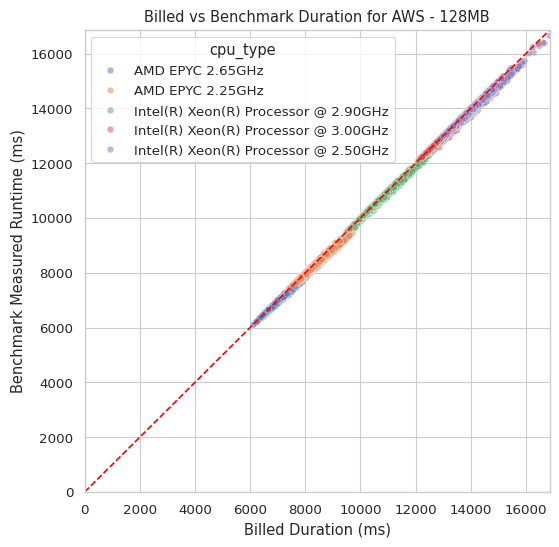

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_billed_vs_benchmark(provider, memory_size_mb):
    subset = df[(df["provider"] == provider) & (df["memory_size_mb"] == memory_size_mb) & (df["billed_duration_ms"].notnull())]

    # print id of records that have no new container but invocation count 1
    no_new_container = subset[(subset["new_container"] == 0)]
    print(no_new_container[["uuid", "new_container", "invocation_count"]])

    print(f"Plotting {provider} with {memory_size_mb}MB: {len(subset)} records")
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=subset,
        x="billed_duration_ms",
        y="runtime_ms",
        hue="cpu_type",
        alpha=0.5,
    )

    max_val = max(subset["billed_duration_ms"].max(), subset["runtime_ms"].max())
    plt.plot([0, max_val], [0, max_val], color="red", linestyle="--")
    plt.title(f"Billed vs Benchmark Duration for {provider.upper()} - {memory_size_mb}MB")
    plt.xlabel("Billed Duration (ms)")
    plt.ylabel("Benchmark Measured Runtime (ms)")
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    plt.grid(True)
    plt.show()

# Example usage:
plot_billed_vs_benchmark("aws", 128)

💾 Saved to: plots/stage_b/cpu_composition.pdf


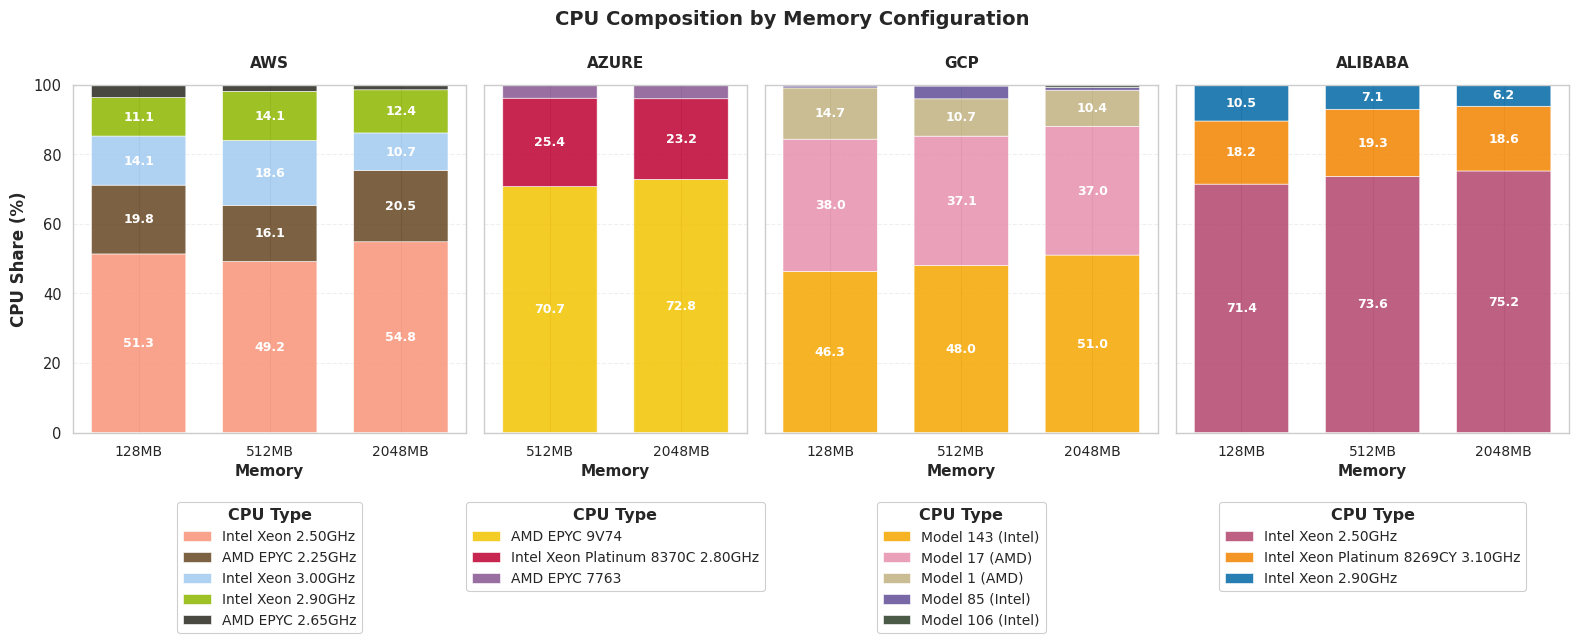

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import FancyBboxPatch
from helpers.cpus import shorten_cpu_name, get_cpu_color


def plot_stage_b_cpu_composition(
    df: pd.DataFrame,
    benchmark: str = "gemm",
    save_path: str | None = None,
    show: bool = True,
):
    """
    Plot CPU share across all providers and memory configurations.
    
    Creates vertical stacked bars showing CPU distribution:
    - 4 subplots (one per provider)
    - X-axis: Memory configurations (128MB, 512MB, 2048MB)
    - Y-axis: CPU Share (%)
    - Colors: Provider-aware CPU colors
    
    Expects df to be pre-filtered (warm invocations, outliers removed).
    """
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    
    # Collect data for all configurations
    results = []
    
    for provider in providers:
        # Azure only has 512MB and 2048MB
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        for memory_size in provider_memory_sizes:
            subset = df[
                (df["provider"] == provider) &
                (df["memory_size_mb"] == memory_size) &
                (df["benchmark_type"] == benchmark)
            ]
            
            if subset.empty:
                print(f"⚠️  No data for {provider} {memory_size}MB")
                continue
            
            # Calculate CPU distribution
            cpu_counts = subset.groupby("cpu_type").size()
            total = cpu_counts.sum()
            
            for cpu, count in cpu_counts.items():
                results.append({
                    "provider": provider,
                    "memory_size": memory_size,
                    "cpu_type": cpu,
                    "count": count,
                    "percentage": (count / total * 100)
                })
    
    results_df = pd.DataFrame(results)
    
    if results_df.empty:
        print("❌ No data to plot")
        return None
    
    # Create figure with 4 subplots - Azure is 2/3 width
    fig, axes = plt.subplots(
        1, 4, figsize=(16, 6), sharey=True,
        gridspec_kw={'width_ratios': [3, 2, 3, 3]}
    )
    
    bar_width = 0.7
    
    for idx, provider in enumerate(providers):
        ax = axes[idx]
        
        # Azure only has 512MB and 2048MB
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes
        
        # Filter data for this provider
        provider_data = results_df[results_df["provider"] == provider]
        
        n_configs = len(provider_memory_sizes)
        x_positions = np.arange(n_configs)
        
        if provider_data.empty:
            ax.text(0.5, 0.5, "No data", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xticks(x_positions)
            ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
            ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=12)
            continue
        
        # Get unique CPUs for this provider
        # Get unique CPUs sorted by total share (descending) - largest at bottom
        cpu_totals = provider_data.groupby("cpu_type")["percentage"].sum()
        provider_cpus = cpu_totals.sort_values(ascending=False).index.tolist()
                
        # Build pivot data
        pivot_data = {}
        for mem_size in provider_memory_sizes:
            mem_data = provider_data[provider_data["memory_size"] == mem_size]
            pivot_data[mem_size] = {
                row["cpu_type"]: row["percentage"]
                for _, row in mem_data.iterrows()
            }
        
        # Plot stacked bars with rounded corners
        bottom_positions = np.zeros(n_configs)
        legend_entries = {}
        
        for cpu_name in provider_cpus:
            heights = [
                pivot_data[mem_size].get(cpu_name, 0)
                for mem_size in provider_memory_sizes
            ]
            
            # Get color for this CPU with provider context
            color = get_cpu_color(cpu_name, provider=provider)
            
            # Draw rounded rectangles manually
            for i, height in enumerate(heights):
                if height > 0:
                    x_pos = x_positions[i] - bar_width / 2
                    y_pos = bottom_positions[i]
                    
                    # Create rounded rectangle
                    fancy_box = FancyBboxPatch(
                        (x_pos, y_pos), bar_width, height,
                        boxstyle="round,pad=0.01",
                        edgecolor='white', facecolor=color,
                        linewidth=0.5, alpha=0.85,
                        transform=ax.transData
                    )
                    ax.add_patch(fancy_box)
                    
                    # Add percentage label (no % symbol)
                    if height > 5:
                        ax.text(
                            x_positions[i], y_pos + height / 2, 
                            f'{height:.1f}',  # <-- No % symbol
                            ha='center', va='center', 
                            fontweight='bold', color='white', fontsize=9
                        )
                    
                    # Add to legend (only once per CPU)
                    if cpu_name not in legend_entries:
                        cpu_label = shorten_cpu_name(cpu_name)
                        legend_entries[cpu_name] = (fancy_box, cpu_label)
            
            bottom_positions += np.array(heights)
        
        # Styling
        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"{mem}MB" for mem in provider_memory_sizes], fontsize=10)
        ax.set_xlabel("Memory", fontweight='bold', fontsize=11)
        ax.set_ylim(0, 100)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)
        
        # Tighter x-limits to squeeze bars together
        ax.set_xlim(-0.5, n_configs - 0.5)
        
        # Provider title
        ax.set_title(f"{provider.upper()}", fontweight='bold', fontsize=11, pad=12)
        
        # Add legend for this provider (below the plot)
        if legend_entries:
            handles = [entry[0] for entry in legend_entries.values()]
            labels = [entry[1] for entry in legend_entries.values()]
            leg = ax.legend(
                handles, labels, 
                title="CPU Type",
                loc='upper center', 
                bbox_to_anchor=(0.5, -0.18), 
                framealpha=0.95, 
                fontsize=10, 
                ncol=1
            )
            leg.get_title().set_fontweight("bold")
    
    # Set y-axis label only on leftmost plot
    axes[0].set_ylabel("CPU Share (%)", fontweight='bold', fontsize=12)
    
    # Title
    fig.suptitle(
        "CPU Composition by Memory Configuration",
        fontsize=14, fontweight='bold', y=0.985
    )
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.86, bottom=0.28, wspace=0.05)
    
    # Save
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", format='pdf')
        print(f"💾 Saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig


# === Usage ===
fig = plot_stage_b_cpu_composition(
    df,
    benchmark="gemm",
    save_path="plots/stage_b/cpu_composition.pdf"
)

Processing Stage B Cost Plot (Filtered)...
No data found for azure - 128MB - gemm - region: None
Using duration column: multiplication_time_ms
💾 Saved to: ../holy/plots/StageB/stage_b_cost_comparison_filtered.pdf


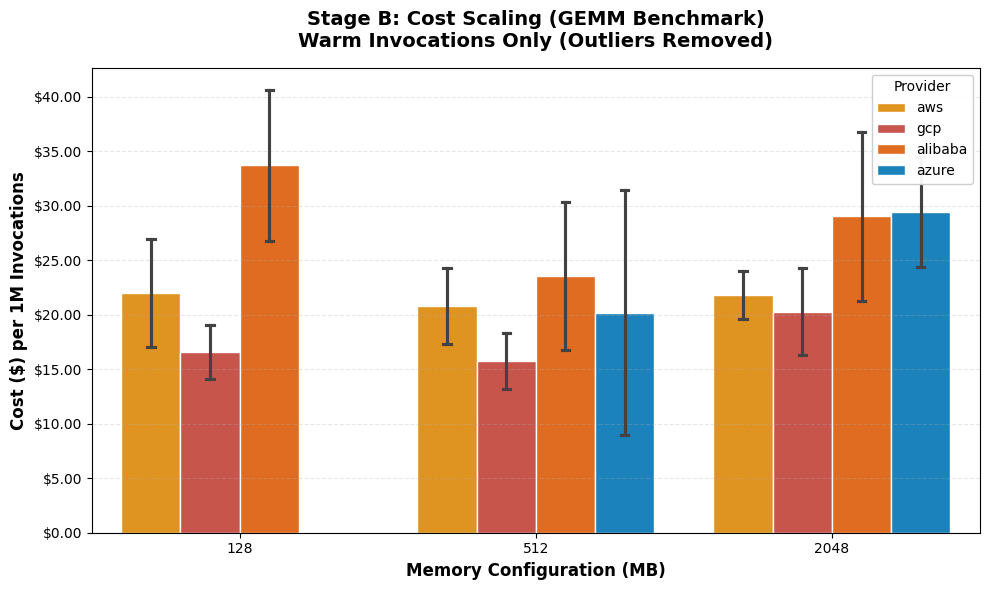

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import os

# --- IMPORT YOUR HELPER ---
from helpers.cost import calculate_cost
from helpers.benchmark import metric_for_benchmark
from helpers.benchmark import filter_cpu_data

def plot_stage_b_cost(df, save_dir="../holy/plots/StageB"):
    print("Processing Stage B Cost Plot (Filtered)...")
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memories = [128, 512, 2048]
    benchmark = "gemm"
    
    filtered_datasets = []

    # --- 1. Apply Strict Filtering Loop ---
    for provider in providers:
        for mem in memories:
            # Azure usually only has 512 and 2048, but filter_cpu_data handles this safely
            clean_df = filter_cpu_data(
                df, 
                provider=provider, 
                memory_size=mem, 
                benchmark=benchmark, 
                group_on_timestamp=False, # As requested
                remove_cold=True          # As requested
            )
            
            if not clean_df.empty:
                filtered_datasets.append(clean_df)

    if not filtered_datasets:
        print("❌ No data found after filtering.")
        return

    # Combine all clean chunks
    plot_df = pd.concat(filtered_datasets, ignore_index=True)
    
    # --- 2. Calculate Cost ---
    # Determine which column holds the duration
    metric_col = metric_for_benchmark(benchmark) # "multiplication_time_ms"
    if metric_col not in plot_df.columns:
        metric_col = "runtime_ms" # Fallback
    
    print(f"Using duration column: {metric_col}")

    plot_df["cost_usd"] = plot_df.apply(
        lambda row: calculate_cost(
            provider=row["provider"],
            memory_mb=row["memory_size_mb"],
            duration_ms=row[metric_col]
        ), axis=1
    )
    plot_df["cost_per_1m"] = plot_df["cost_usd"] * 1_000_000

    # --- 3. Plotting ---
    provider_colors = {
        "aws": "#FF9900", "azure": "#0089D6", 
        "gcp": "#DB4437", "alibaba": "#FF6600"
    }

    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        data=plot_df,
        x="memory_size_mb",
        y="cost_per_1m",
        hue="provider",
        palette=provider_colors,
        errorbar="sd", # Shows variance in cost (caused by performance variance)
        capsize=0.1,
        edgecolor="white",
        linewidth=1
    )

    ax.set_title("Stage B: Cost Scaling (GEMM Benchmark)\nWarm Invocations Only (Outliers Removed)", 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Memory Configuration (MB)", fontweight='bold', fontsize=12)
    ax.set_ylabel("Cost ($) per 1M Invocations", fontweight='bold', fontsize=12)
    
    fmt = '${x:,.2f}'
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.legend(title="Provider", loc='upper right', framealpha=0.95)

    plt.tight_layout()
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, "stage_b_cost_comparison_filtered.pdf")
        plt.savefig(out_path, bbox_inches="tight", format='pdf')
        print(f"💾 Saved to: {out_path}")
        
    plt.show()

# Run it
# plot_stage_b_cost(df)
# Usage:
plot_stage_b_cost(df)

Saved: plots/stage_b/deviation_from_median.pdf


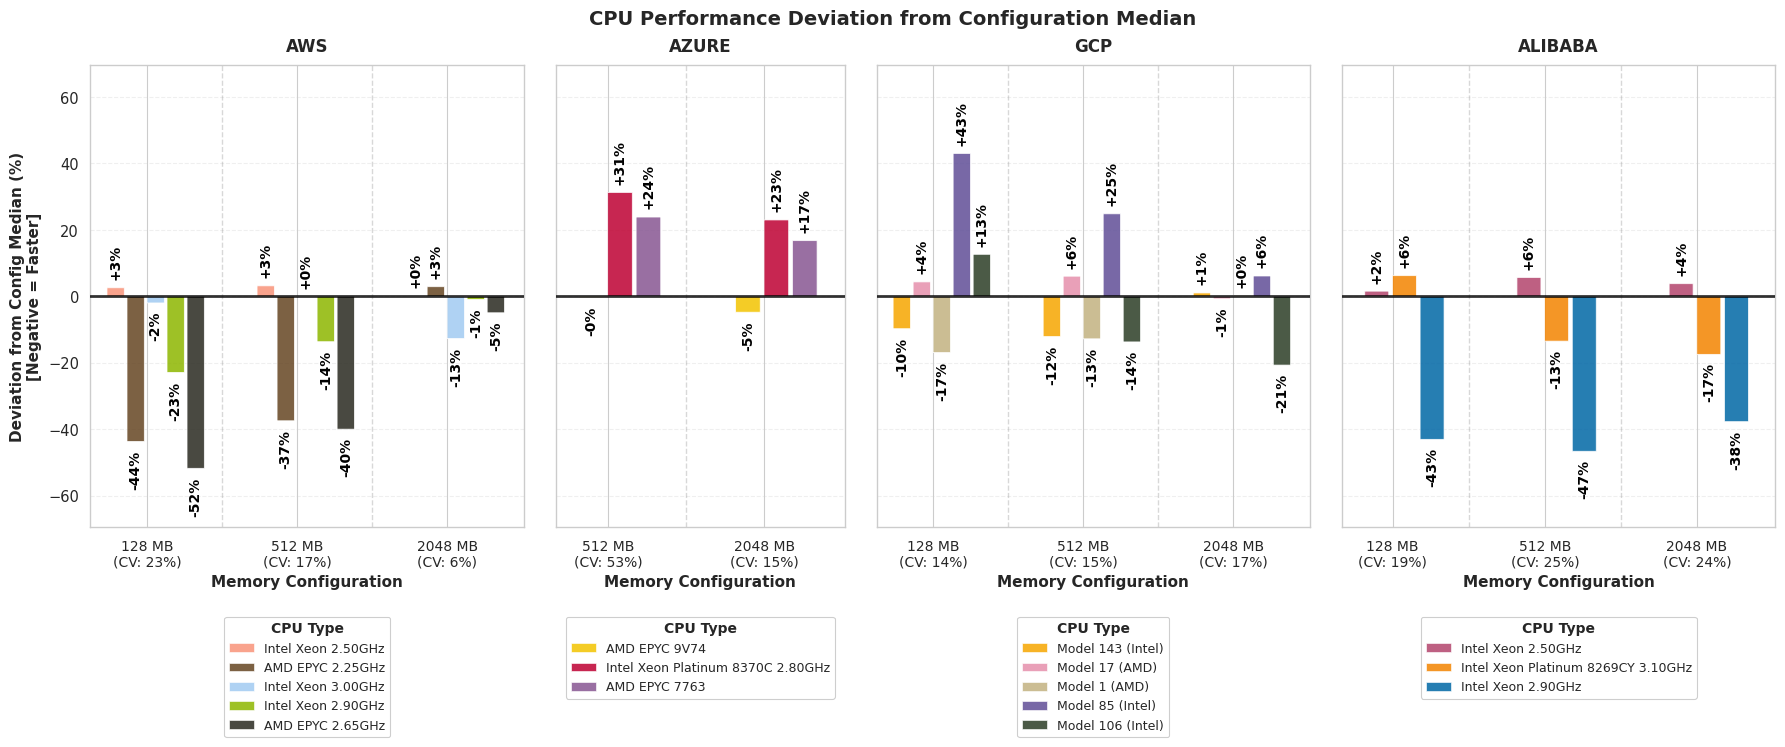

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_color

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def plot_stage_b_deviation(
    df: pd.DataFrame,
    benchmark: str = "gemm",
    save_path: str | None = None,
    show: bool = True,
) -> plt.Figure:
    """
    Stage B: CPU performance deviation from configuration median.
    
    Shows how each CPU type's median performance compares to the 
    overall median for that (provider, memory) configuration.
    Includes CV annotation per config to show overall variability.
    
    Interpretation:
      - 0%  = equals config median
      - <0% = faster than config median (lower execution time)
      - >0% = slower than config median (higher execution time)
    
    Parameters
    ----------
    df : pd.DataFrame
        Pre-filtered DataFrame (warm invocations, outliers removed).
    benchmark : str
        Benchmark type (default: "gemm").
    save_path : str | None
        Path to save figure (creates directories if needed).
    show : bool
        Whether to display the figure.
    
    Returns
    -------
    plt.Figure
        The generated figure.
    """

    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    metric = metric_for_benchmark(benchmark)

    fig, axes = plt.subplots(
        1, 4, figsize=(18, 7), sharey=True,
        gridspec_kw={"width_ratios": [3, 2, 3, 3]}
    )

    global_changes = []

    for idx, provider in enumerate(providers):
        ax = axes[idx]
        provider_memory_sizes = [512, 2048] if provider == "azure" else memory_sizes

        # Subset data for this provider
        provider_df = df[
            (df["provider"] == provider) &
            (df["benchmark_type"] == benchmark)
        ]
        
        if provider_df.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(f"{provider.upper()}", fontweight="bold", fontsize=11, pad=15)
            ax.axis("off")
            continue

        # Stable CPU order (by overall instance frequency across all configs)
        provider_cpu_order = (
            provider_df.groupby("cpu_type")["instance_id"]
            .nunique()
            .sort_values(ascending=False)
            .index
            .tolist()
        )

        # Compute deviation and CV per config
        all_plot_data = {}
        config_cvs = {}

        for memory_size in provider_memory_sizes:
            config_df = provider_df[provider_df["memory_size_mb"] == memory_size]
            
            if config_df.empty or metric not in config_df.columns:
                all_plot_data[memory_size] = {}
                config_cvs[memory_size] = None
                continue

            # Per-instance median (analysis unit)
            inst_medians = (
                config_df
                .groupby(["cpu_type", "instance_id"], as_index=False)[metric]
                .median()
                .rename(columns={metric: "inst_median"})
            )
            
            # Config-level statistics
            config_median = inst_medians["inst_median"].median()
            config_std = inst_medians["inst_median"].std()
            config_mean = inst_medians["inst_median"].mean()
            
            # CV based on instance medians (shows hardware lottery effect)
            if pd.notna(config_mean) and config_mean > 0:
                config_cvs[memory_size] = (config_std / config_mean) * 100
            else:
                config_cvs[memory_size] = None

            if not pd.notna(config_median) or config_median <= 0:
                all_plot_data[memory_size] = {}
                continue

            # CPU-level medians and deviation calculation
            cpu_medians = inst_medians.groupby("cpu_type")["inst_median"].median()
            
            pct_map = {
                cpu: (cpu_med - config_median) / config_median * 100.0
                for cpu, cpu_med in cpu_medians.items()
            }
            all_plot_data[memory_size] = pct_map

        # === Bar layout ===
        bar_width = 0.6
        config_gap = 1.5
        current_x = 0.0

        config_centers = []
        bar_positions = []

        for memory_size in provider_memory_sizes:
            pct_map = all_plot_data.get(memory_size, {})
            cpus_in_config = [cpu for cpu in provider_cpu_order if cpu in pct_map]

            if not cpus_in_config:
                config_centers.append(current_x)
                current_x += config_gap
                continue

            n_bars = len(cpus_in_config)
            config_start = current_x

            for bar_idx, cpu in enumerate(cpus_in_config):
                x_pos = config_start + bar_idx * bar_width
                bar_positions.append({
                    "x": x_pos,
                    "memory_size": memory_size,
                    "cpu": cpu,
                    "pct_change": float(pct_map[cpu]),
                })

            config_center = config_start + (n_bars - 1) * bar_width / 2
            config_centers.append(config_center)
            current_x = config_start + n_bars * bar_width + config_gap

        # === Draw bars ===
        for bd in bar_positions:
            x_pos = bd["x"]
            pct_change = bd["pct_change"]
            cpu = bd["cpu"]
            color = get_cpu_color(cpu, provider=provider)
            bar_w = bar_width * 0.85

            # Draw bar (direction depends on sign)
            if pct_change < 0:
                patch = FancyBboxPatch(
                    (x_pos, pct_change), bar_w, -pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor="white", facecolor=color,
                    linewidth=0.6, alpha=0.85
                )
            else:
                patch = FancyBboxPatch(
                    (x_pos, 0), bar_w, pct_change,
                    boxstyle="round,pad=0.005",
                    edgecolor="white", facecolor=color,
                    linewidth=0.6, alpha=0.85
                )
            ax.add_patch(patch)

            # Label outside bar
            offset = 2.5
            label_y = pct_change + offset if pct_change >= 0 else pct_change - offset
            va = "bottom" if pct_change >= 0 else "top"

            ax.text(
                x_pos + bar_w / 2, label_y,
                f"{pct_change:+.0f}%",
                ha="center", va=va,
                fontsize=10, fontweight="bold", color="black",
                rotation=90, clip_on=False, zorder=20
            )
            global_changes.append(pct_change)

        # === Config separators ===
        for i in range(len(provider_memory_sizes) - 1):
            if i < len(config_centers) - 1:
                sep_x = (config_centers[i] + config_centers[i + 1]) / 2
                ax.axvline(sep_x, color="gray", linestyle="--", 
                          linewidth=1, alpha=0.3, zorder=1)

        # === Zero reference line ===
        ax.axhline(0, color="black", linestyle="-", linewidth=2, alpha=0.8, zorder=10)

        # === Axis labels ===
        if idx == 0:
            ax.set_ylabel("Deviation from Config Median (%)\n[Negative = Faster]", 
                         fontweight="bold", fontsize=11)

        # X-axis: Memory labels with CV annotation
        x_labels = []
        for mem, cv in zip(provider_memory_sizes, 
                          [config_cvs.get(m) for m in provider_memory_sizes]):
            if cv is not None:
                x_labels.append(f"{mem} MB\n(CV: {cv:.0f}%)")
            else:
                x_labels.append(f"{mem} MB")

        ax.set_xticks(config_centers)
        ax.set_xticklabels(x_labels, fontsize=10)
        ax.set_xlabel("Memory Configuration", fontweight="bold", fontsize=11)
        ax.grid(True, axis="y", linestyle="--", alpha=0.3, zorder=0)

        ax.set_title(provider.upper(), fontweight="bold", fontsize=12, pad=10)

        if bar_positions:
            ax.set_xlim(-0.5, max(b["x"] for b in bar_positions) + bar_width + 0.5)

        # === Per-provider legend ===
        legend_handles = [
            Rectangle((0, 0), 1, 1, facecolor=get_cpu_color(cpu, provider), 
                      edgecolor="white", linewidth=0.5, alpha=0.85)
            for cpu in provider_cpu_order
        ]
        legend_labels = [shorten_cpu_name(cpu) for cpu in provider_cpu_order]

        leg = ax.legend(
            legend_handles, legend_labels,
            loc="upper center", bbox_to_anchor=(0.5, -0.18),
            framealpha=0.95, fontsize=9, ncol=1,
            title="CPU Type", title_fontsize=10
        )

        leg.get_title().set_fontweight("bold")

    # === Shared y-limits ===
    if global_changes:
        max_abs = max(abs(min(global_changes)), abs(max(global_changes)))
        pad = 10
        for ax in axes:
            ax.set_ylim(-(max_abs * 1.15 + pad), (max_abs * 1.15 + pad))

    fig.suptitle(
        "CPU Performance Deviation from Configuration Median",
        fontsize=14, fontweight="bold", y=0.98
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.24, wspace=0.08)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved: {save_path}")

    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig

# === Usage ===
fig = plot_stage_b_deviation(
    df,
    benchmark="gemm",
    save_path="plots/stage_b/deviation_from_median.pdf"
)

In [ ]:
import pandas as pd
import numpy as np

from helpers.benchmark import filter_cpu_data, metric_for_benchmark


def _cv_percent(x: pd.Series) -> float:
    x = x.dropna()
    if len(x) < 2:
        return np.nan
    m = x.mean()
    s = x.std(ddof=1)
    return (s / m * 100.0) if (pd.notna(m) and m > 0) else np.nan


def build_stage_b_cv_tables(
    df: pd.DataFrame,
    benchmark: str = "gemm",
    providers: list[str] = ["aws", "azure", "gcp", "alibaba"],
    memories: list[int] = [128, 512, 2048],
    min_instances_per_cell: int = 5,
    group_on_timestamp: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      overall_df:  provider, memory_size_mb, n_instances, mean, std, cv
      cpu_df:      provider, memory_size_mb, cpu_type, n_instances, mean, std, cv

    CV is computed across per-instance warm means.
    """
    metric = metric_for_benchmark(benchmark)

    all_inst = []

    for provider in providers:
        for mem in memories:
            clean = filter_cpu_data(
                df=df,
                provider=provider,
                memory_size=mem,
                benchmark=benchmark,
                group_on_timestamp=group_on_timestamp,
                remove_cold=True,
            )
            if clean.empty or metric not in clean.columns:
                continue

            clean = clean.dropna(subset=["instance_id", "cpu_type", metric])

            # per-instance warm mean = one sample per instance
            inst = (
                clean.groupby(["provider", "memory_size_mb", "cpu_type", "instance_id"], as_index=False)[metric]
                .mean()
                .rename(columns={metric: "inst_warm_mean"})
            )
            all_inst.append(inst)

    if not all_inst:
        return (
            pd.DataFrame(columns=["provider", "memory_size_mb", "n_instances", "mean", "std", "cv"]),
            pd.DataFrame(columns=["provider", "memory_size_mb", "cpu_type", "n_instances", "mean", "std", "cv"]),
        )

    inst_df = pd.concat(all_inst, ignore_index=True)

    # Overall CV per provider x memory (pooling all CPUs)
    overall_df = (
        inst_df.groupby(["provider", "memory_size_mb"])["inst_warm_mean"]
        .agg(
            n_instances="count",
            mean="mean",
            std=lambda x: x.std(ddof=1),
            cv=_cv_percent,
        )
        .reset_index()
    )

    # Within-CPU CV per provider x memory x cpu
    cpu_df = (
        inst_df.groupby(["provider", "memory_size_mb", "cpu_type"])["inst_warm_mean"]
        .agg(
            n_instances="count",
            mean="mean",
            std=lambda x: x.std(ddof=1),
            cv=_cv_percent,
        )
        .reset_index()
    )

    # Optional: drop cells with too few instances (stabilizes CV)
    if min_instances_per_cell is not None and min_instances_per_cell > 1:
        cpu_df.loc[cpu_df["n_instances"] < min_instances_per_cell, ["cv", "std"]] = np.nan

    # Sort (CPU by name)
    overall_df = overall_df.sort_values(["provider", "memory_size_mb"])
    cpu_df = cpu_df.sort_values(["provider", "memory_size_mb", "cpu_type"])

    # Sanity check: GCP absolute std vs relative CV
    check = cpu_cv_df[cpu_cv_df["provider"] == "gcp"][["memory_size_mb", "cpu_type", "mean", "std", "cv"]]
    print("GCP: absolute std vs CV across memory tiers:")
    print(check.sort_values(["cpu_type", "memory_size_mb"]).to_string(index=False))

    return overall_df, cpu_df


# Usage
overall_cv_df, cpu_cv_df = build_stage_b_cv_tables(df, benchmark="gemm")
overall_cv_df, cpu_cv_df


No data found for azure - 128MB - gemm - region: None


(Empty DataFrame
 Columns: [provider, memory_size_mb, n_instances, mean, std, cv]
 Index: [],
 Empty DataFrame
 Columns: [provider, memory_size_mb, cpu_type, n_instances, mean, std, cv]
 Index: [])

Saved: plots/stage_b/cv_heatmap.pdf


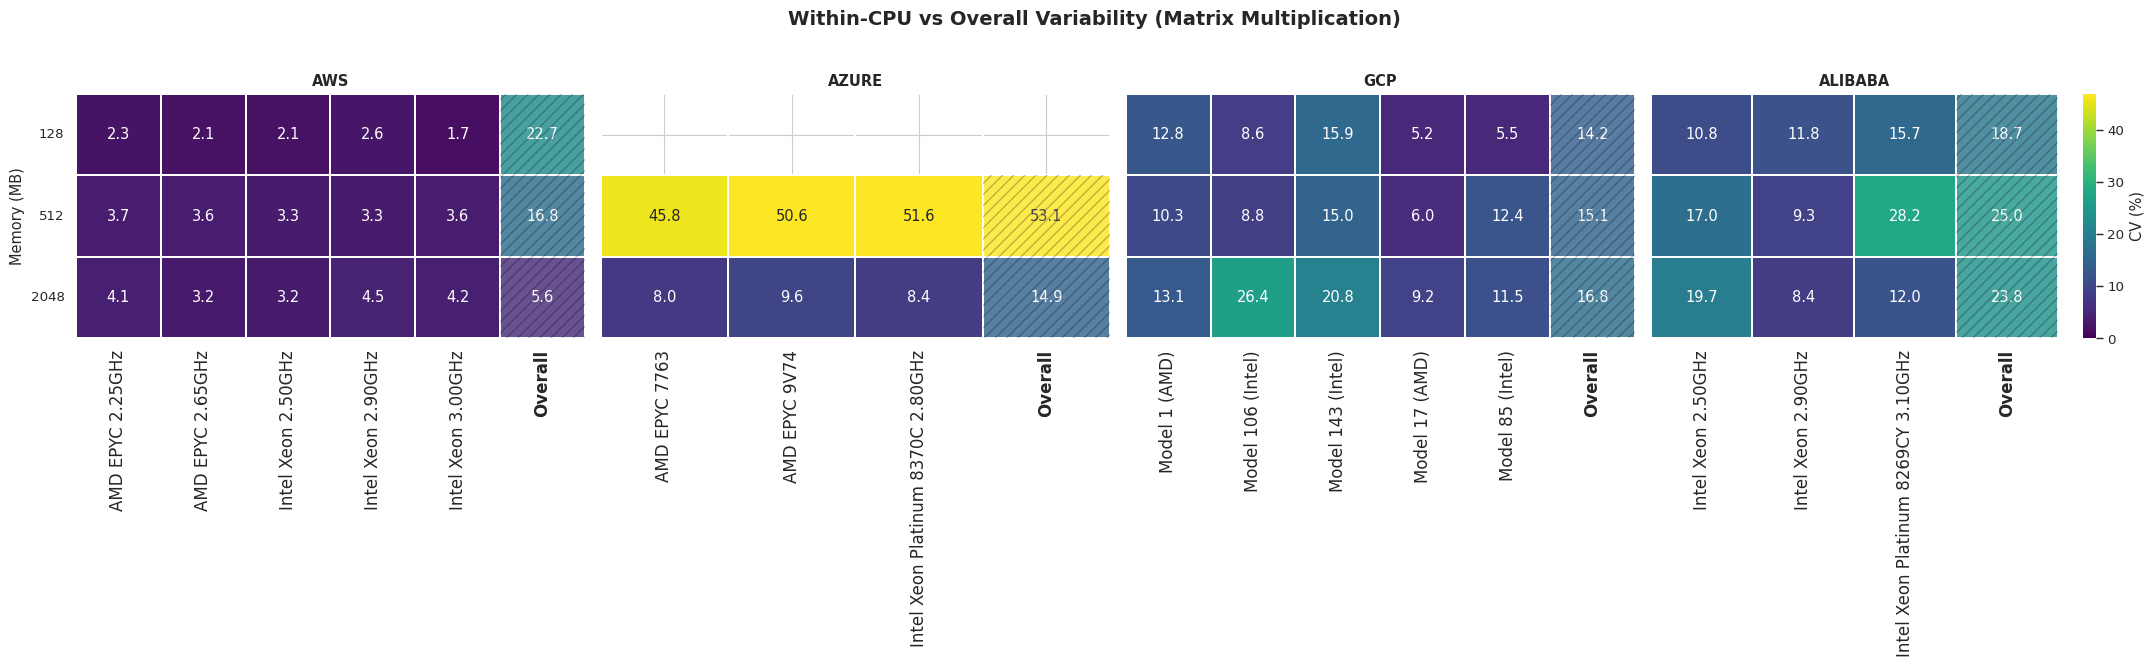

In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from helpers.benchmark import metric_for_benchmark
from helpers.cpus import shorten_cpu_name

sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)


def plot_stage_b_cv_heatmap(
    df: pd.DataFrame,
    benchmark: str = "gemm",
    save_path: str | None = None,
    show: bool = True,
    hatch: str = "///",
    hatch_alpha: float = 0.18,
) -> plt.Figure:
    """
    Stage B: CV heatmap showing within-CPU vs overall variability.
    
    Computes standard CV (std/mean × 100%) on per-instance medians.
    'Overall' column shows config-level CV across all CPUs.
    
    Parameters
    ----------
    df : pd.DataFrame
        Pre-filtered DataFrame (warm invocations, outliers removed).
    benchmark : str
        Benchmark type (default: "gemm").
    save_path : str | None
        Path to save figure (creates directories if needed).
    show : bool
        Whether to display the figure.
    hatch : str
        Hatch pattern for Overall column.
    hatch_alpha : float
        Transparency of hatch overlay.
    
    Returns
    -------
    plt.Figure
        The generated figure.
    """
    
    providers = ["aws", "azure", "gcp", "alibaba"]
    memory_sizes = [128, 512, 2048]
    metric = metric_for_benchmark(benchmark)
    
    # Filter to benchmark
    bench_df = df[df["benchmark_type"] == benchmark].copy()
    
    if bench_df.empty:
        print(f"❌ No data for benchmark: {benchmark}")
        return None
    
    # === Build CV tables from per-instance medians ===
    cpu_cv_records = []
    overall_cv_records = []
    
    for provider in providers:
        provider_memories = [512, 2048] if provider == "azure" else memory_sizes
        
        for mem in provider_memories:
            config_df = bench_df[
                (bench_df["provider"] == provider) &
                (bench_df["memory_size_mb"] == mem)
            ]
            
            if config_df.empty or metric not in config_df.columns:
                continue
            
            # Per-instance medians (analysis unit)
            inst_medians = (
                config_df
                .groupby(["cpu_type", "instance_id"], as_index=False)[metric]
                .median()
                .rename(columns={metric: "inst_median"})
            )
            
            # Overall CV (across all instances in config)
            config_mean = inst_medians["inst_median"].mean()
            config_std = inst_medians["inst_median"].std()
            
            if pd.notna(config_mean) and config_mean > 0:
                overall_cv = (config_std / config_mean) * 100
                overall_cv_records.append({
                    "provider": provider,
                    "memory_size_mb": mem,
                    "cv": overall_cv,
                })
            
            # Within-CPU CV
            for cpu_type in inst_medians["cpu_type"].unique():
                cpu_inst = inst_medians[inst_medians["cpu_type"] == cpu_type]["inst_median"]
                
                if len(cpu_inst) < 2:
                    continue
                
                cpu_mean = cpu_inst.mean()
                cpu_std = cpu_inst.std()
                
                if pd.notna(cpu_mean) and cpu_mean > 0:
                    cpu_cv = (cpu_std / cpu_mean) * 100
                    cpu_cv_records.append({
                        "provider": provider,
                        "memory_size_mb": mem,
                        "cpu_type": cpu_type,
                        "cv": cpu_cv,
                    })
    
    cpu_cv_df = pd.DataFrame(cpu_cv_records)
    overall_cv_df = pd.DataFrame(overall_cv_records)
    
    if cpu_cv_df.empty:
        print("❌ No CV data to plot")
        return None
    
    # === Shared color scale (robust) ===
    vals = []
    if cpu_cv_df["cv"].notna().any():
        vals.append(cpu_cv_df["cv"].values)
    if not overall_cv_df.empty and overall_cv_df["cv"].notna().any():
        vals.append(overall_cv_df["cv"].values)
    
    if vals:
        all_cv = np.concatenate([v[~np.isnan(v)] for v in vals])
        vmax = float(np.nanpercentile(all_cv, 95)) if len(all_cv) else 1.0
        vmax = max(vmax, 1.0)
    else:
        vmax = 1.0
    vmin = 0.0
    
    # === Create figure ===
    n = len(providers)
    fig, axes = plt.subplots(1, n, figsize=(5.5 * n, 6.5), sharey=True)
    if n == 1:
        axes = [axes]
    
    for i, provider in enumerate(providers):
        ax = axes[i]
        
        sub_cpu = cpu_cv_df[cpu_cv_df["provider"] == provider].copy()
        
        if sub_cpu.empty:
            ax.axis("off")
            ax.set_title(provider.upper(), fontweight="bold")
            continue
        
        # Pivot for heatmap - always use full memory_sizes for consistent y-axis
        pivot = (
            sub_cpu
            .pivot_table(index="memory_size_mb", columns="cpu_type", values="cv", aggfunc="mean")
            .reindex(index=memory_sizes)  # Always 128, 512, 2048
        )
        
        # Append Overall column
        if not overall_cv_df.empty:
            sub_overall = overall_cv_df[overall_cv_df["provider"] == provider].copy()
            overall_series = sub_overall.set_index("memory_size_mb")["cv"].reindex(memory_sizes)
            pivot["Overall"] = overall_series
        
        # Shorten CPU labels, keep Overall
        cols = []
        for c in pivot.columns:
            cols.append("Overall" if c == "Overall" else shorten_cpu_name(str(c)))
        pivot.columns = cols
        
        # Ensure Overall last
        if "Overall" in pivot.columns:
            cols = [c for c in pivot.columns if c != "Overall"] + ["Overall"]
            pivot = pivot[cols]
        
        sns.heatmap(
            pivot,
            ax=ax,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".1f",
            linewidths=0.3,
            linecolor="white",
            cbar=(i == n - 1),
            cbar_kws={"label": "CV (%)"},
        )
        
        # Hatch overlay for Overall column
        if "Overall" in pivot.columns:
            j = list(pivot.columns).index("Overall")
            for r in range(pivot.shape[0]):
                val = pivot.iloc[r, j]
                if pd.isna(val):
                    continue
                
                ax.add_patch(
                    Rectangle(
                        (j, r), 1, 1,
                        fill=True,
                        facecolor=(1, 1, 1, hatch_alpha),
                        edgecolor=(0, 0, 0, 0.25),
                        linewidth=0.0,
                        hatch=hatch,
                        zorder=9,
                    )
                )
            
            # Bold tick label for "Overall"
            for t in ax.get_xticklabels():
                if t.get_text() == "Overall":
                    t.set_fontweight("bold")
        
        ax.set_title(provider.upper(), fontweight="bold")
        ax.set_ylabel("Memory (MB)" if i == 0 else "")
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=90, labelsize=12)
        ax.tick_params(axis="y", rotation=0)
    
    fig.suptitle(
        "Within-CPU vs Overall Variability (Matrix Multiplication)",
        fontsize=14, fontweight="bold", y=1.02
    )
    
    plt.tight_layout()
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
        print(f"Saved: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close(fig)
    
    return fig


# === Usage ===
fig = plot_stage_b_cv_heatmap(
    df,  # Pre-filtered via build_stage_b_filtered_df
    benchmark="gemm",
    save_path="plots/stage_b/cv_heatmap.pdf"
)

In [15]:
import seaborn as sns

df_filtered = df[(df["provider"] == "gcp") & (df["memory_size_mb"] == 2048) & (df["cpu_type"] == "Model 106 (Intel)")]



# make one string from flags list
df_filtered["flags"] = df_filtered["flags"].apply(lambda x: ",".join(sorted(x)) if isinstance(x, list) else "")
print(len(df_filtered["flags"].unique()))



# sns.swarmplot(
#     df_filtered, x="flags", y="multiplication_time_ms",
# )

1


/tmp/ipykernel_12717/3556453373.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["flags"] = df_filtered["flags"].apply(lambda x: ",".join(sorted(x)) if isinstance(x, list) else "")
